# The BFGS algorithm

One of the most popular quasi-Newton methods is the Broyden-FLetcher-Goldfarb-Shannon (BFGS) method. Here we give a very brief description. See chapter 8 of the book: <font color='blue'>Jorge Nocedal and Stephen J. Wright, 'Numerical Optimization', Springer, 1999 </font> for details. 

Starting with the quadratic approximation of a function $f(x)$ at itertate $x_k$:
$$m_k(p)=f_k+g_k^{T}p + \frac{1}{2} p^T B_k p$$
where $g_k = \nabla{f_k}$, the quasi-Newton methods replace the hessian with an approximation $B_k$ and they update this approximation in each iteration of teh algorithm. Given that this matrix need to be inversed (a computationally expensive step), some algorithms use an update formula for the inverse.It's worth noting that for $p=0$ the value and the gradient of this model match exactly $f(x)$ and $\nabla{f(x)}$ respectively. Minimizing $m_k(p)$ gives
$$p_k=-B_k^{-1} \nabla{f_k}$$
and using this minimizer for the search direction we get the new iterate 
$$x_{k+1}=x_k+ \alpha_k p _k$$
where $\alpha_k$ is satisfying curvature and decrease conditions (known as *Wolfe conditions*). This is the Newton update and the only difference is that we don't use the Hessian but its approximation $B_k$. Adding the requirement that gradient of $m_{k+1}$ matches that of $f(x)$ at the last two iterates $x_k$ and $x_{k+1}$ we get the so called *secant equation* 
$$B_{k+1} s_k= y_k$$
where $s_k=x_{k+1}-x_k$ and $y_k=\nabla{f_{k+1}}-\nabla{f_k}$.

Under certain curvature satisfying conditions the secant equation will provide sevral solutions for $B_{k+1}$. Requiring $B_{k+1}$ to be as close as possible to $B_k$ using some measure of closeness. This leads to the update formula
$$B_{k+1}=(I-\gamma_k y_ks_k^T) B_k (I-\gamma_k s_k y_k^T)+\gamma_k y_k y_k^T$$
which is the Davidon, Fletcher, Powell (DFP) update. 

The BFGS update is simlar but requires that similar conditions that DFP puts on $B_{k+1}$ are applied to the **inverse** $H_{k+1}$ of $B_{k+1}$, thus providing the following update for $H_k$:
$$H_{k+1}=(I-\rho_k s_k y_k^T) H_k (I - \rho_k y_k s_k^T) + \rho_k s_k s_k^T$$
where $\rho=\frac{1}{y_k^T s_k}$.

The BFGS algorithm is now described as:
1. Start with initial point $x^0$, initial Hessian approximation $H_0$ and tolerance $\epsilon >0$. Set $k=0$
2. Compute search direction $p_k=-H_k \nabla{f_k}$.
3. Set $x_{k+1} = x_k + \alpha_k p_k $
4. Set $s_k=x_{k+1}-x_k$ and $y_k=\nabla{f_{k+1}} - \nabla{f_k}$
5. Compute $H_{k+1}$ form the BFGS update equation above
6. If the norm $\|\nabla{f_{k+1}}\| > \epsilon$ go to Step 2. Otherwise terminate

The choice of $\alpha_k$ in Step 3 is very important for the performance of the algorithm. As stated above $\alpha_k$ must satisfy Wolfe's conditions which are:
$$f(x_k+\alpha_k p_k) \le f(x_k) + c_1 \alpha \nabla{f_k}^T p_k $$
$$\nabla{f(x_k+\alpha_k p_k)}^T p_k \ge c_2 \nabla{f_k}^T p_k$$
with $0 < c_1 < c_2 < 1$. In the code below we use a so called back tracking line search that makes the second inequality redundant. 

In [1]:
import numpy as np
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sympy import *
%matplotlib inline

We define the Rosenbrock function in `sympy` so we can calculate the gradient symbolically.

In [2]:
x1,x2=symbols("x1 x2")
f=Matrix([100*(x2-x1**2)**2+(1-x1)**2])
X=Matrix([x1,x2])
f

Matrix([[(1 - x1)**2 + 100*(-x1**2 + x2)**2]])

The method `find_alpha` is a backtracking line search to find a value for $\alpha_k$ at iteration $k$ that satisfies the Wolfe conditions. It's easy to see how important this is: just replace `alphak` with a constant and see the algorithm diverge to very large numbers.

In [3]:
def find_alpha(x,p,nab):
    fv=lambdify((x1,x2),100*(x2-x1**2)**2+(1-x1)**2)
    rho=0.5 
    c=0.5
    alpha=1.0
    xn=x+alpha* np.transpose(p)
    while fv(xn[0],xn[1]) > fv(x[0],x[1]) + c* alpha * np.matmul(nab,p):
        alpha = rho* alpha
        xn=x+alpha* np.transpose(p)
    return alpha

We initialize the matrix `H` to be the identity matrix, and the point (1,0) to be the starting (guess) point. Also here we specify the tolerance to be `0.001` and the maximum number of iterations to be `1500`. We use that to size the array where we keep the values of the updated `x`.

In [4]:
H=np.identity(2)
epsilon=0.001
mxiter=1500
g=f.jacobian(X)
k=0
xi=np.empty([mxiter,2])
xi[k]=np.array([1,0])
p=np.empty(2)
s=np.empty(2)
y=np.empty(2)
I=np.eye(2)

The loop below is the main execution of the alogirthm. Lines 2-4 correspond to Step 2, lines 5-7 to Step 3, lines 8-10 to Step 4, and lines  11-15 to Step 5. 

In [6]:
while (g.norm().evalf(subs={x1:xi[k][0],x2:xi[k][1]}) > epsilon):
    nab=np.array(g.evalf(subs={x1:xi[k][0],x2:xi[k][1]})).astype(np.float64)
    p= -np.matmul(H,np.transpose(nab))
    p=p.flatten()
    alphak=find_alpha(xi[k],p,nab)
    xi[k+1]=xi[k]+ alphak * np.transpose(p)
    s=xi[k+1]-xi[k]
    nab1=np.array(g.evalf(subs={x1:xi[k+1][0],x2:xi[k+1][1]})).astype(np.float64)
    y=nab1-nab
    rho=1./np.matmul(y,np.transpose(s))
    h1=(I-rho*np.matmul(y,s))
    H=np.matmul(h1,H)
    H=np.matmul(H,np.transpose(h1))
    H=H+rho* np.matmul(np.transpose(s),s)
    k=k+1
print('Terminated after ',k,' iterations with x= ',xi[k])

    

Terminated after  993  iterations with x=  [0.99893494 0.99786648]


The plot below shows the progress of the algorithm (red dots) , as it starts at (1,0) and converges to (1,1).

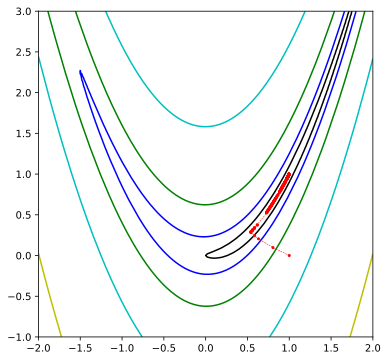

In [7]:
from scipy.optimize import rosen
npts = 201
x, y = np.mgrid[-2:2:npts*1j, -1:3:npts*1j]
x.shape = (npts**2)
y.shape = (npts**2)
z = rosen(np.vstack((x, y)))
x.shape = (npts, npts)
y.shape = (npts, npts)
z.shape = (npts, npts)
fig = plt.figure(figsize=(6,6))
ax1 = fig.subplots()
# Plots/
levels = np.logspace(0, 3.2, 5)
#plt.cla()
ax1.contour(x, y, z, levels,colors = ['k','b','g','c','y'])
ax1.plot(xi[0:993,0],xi[0:993,1],'ro--',markersize=2,linewidth=0.5)

In [323]:
import matplotlib.animation as animation
%matplotlib notebook

<IPython.core.display.Javascript object>


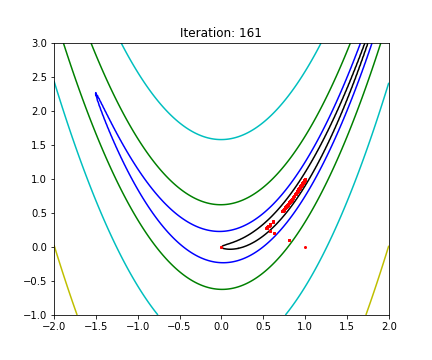

In [330]:
def animate(i):
    plt.plot(xi[i][0],xi[i][1],'ro--',markersize=2)
    plt.title('Iteration: '+str(i))
    return plt
figa=plt.figure(figsize=(6,5))
plt.plot(xi[0][0],xi[0][1],'ro',markersize=2)
plt.contour(x, y, z, levels,colors = ['k','b','g','c','y'])
ani = animation.FuncAnimation(figa,animate,frames=np.arange(1,k+2),interval=60)
#plt.show()